# Spindle detection from LFP
This notebook shows the exploratory analysis for spindle and slow oscillation detection from LFP recording. It has 3 parts:
1. Spindle detection
2. Slow wave detection
3. Spindle-slow wave coupling

For detecting events, like spindles and slow oscillations, we use a python package called `yasa` (Yet Another Spindle Algorithm):
* Vallat, Raphael, and Matthew P. Walker. “An open-source, high-performance tool for automated sleep staging.” Elife 10 (2021). doi: https://doi.org/10.7554/eLife.70092

## Imports and data loading

In [ ]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftfreq
from numpy.fft import fft, ifft
from scipy import fftpack
import scipy.signal as sig
import warnings
import seaborn as sns
import yasa 
from yasa import sw_detect
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mne.filter import resample, filter_data
from tensorpac import Pac

# here change path according to your drive
mat_contents = sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/Spindles_All_StartEndTimes_1SD.mat')
PFC_LFP_spindle = sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/PFC_LFP_filtered_Spindle.mat')
TC_LFP_spindle = sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/A2_Thal_LFP_600Hz.mat')
timestamp = sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/LFP_Timestamp.mat')
sleeptimes = sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/SleepTimes.mat')

# (1296, 2)
spindle_start_end = mat_contents['AllSpindlesStartEnd']
PFC_raw= sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/PFC_LFPraw.mat')
PFC_raw = np.reshape(PFC_raw['LFPRaw'], PFC_raw['LFPRaw'].shape[1])
PFC_LFP_spindle = PFC_LFP_spindle['FilteredLFP_6_14']
PFC_LFP_spindle = np.reshape(PFC_LFP_spindle, PFC_LFP_spindle.shape[1])
TC_LFP_spindle = TC_LFP_spindle['A2_LFP']
TC_LFP_spindle = np.reshape(TC_LFP_spindle, TC_LFP_spindle.shape[1])
T = timestamp['tsRaw']
T = np.reshape(T, T.shape[1])

# Match PFC and Thalamic LFP lengths, Thalamic (TC) LFP is longer
TC_LFP_spindle = TC_LFP_spindle[:PFC_LFP_spindle.shape[0]]
TC_raw = TC_LFP_spindle

# Not necessarily needed
PFC_delta = sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/PFC_LFP_filtered_delta.mat')
PFC_delta = PFC_delta['FilteredLFP_1_4']
PFC_delta = np.reshape(PFC_delta, PFC_delta.shape[1])

# (691, 1)
SO_trough_times= sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/SOs_All_TroughTimes.mat')
SO_trough_times = SO_trough_times['KCtimes']

# (243, 2)
Spindles_after_SOs = sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/SpindlesAfterSO_StartEndTimes.mat')
Spindles_after_SOs = Spindles_after_SOs['SpindlesAfterSOs']

# (961, 2)
Spindles_Not_Coupled = sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/SpindlesUncoupled_StartEndTimes.mat')
Spindles_Not_Coupled = Spindles_Not_Coupled['SpindlesNotCoupled']

#This file is all zeros
SO_SpindleCoupled_Waveforms= sio.loadmat('/your_drive//Rat Data/SampleSession_Rat20/SOs_SpindleCoupled_Waveforms.mat')
SO_SpindleCoupled_Waveforms = SO_SpindleCoupled_Waveforms['AllWaveforms']


## Spindle detection from PFC and Thalamus (TC)

### Visualize some LFP

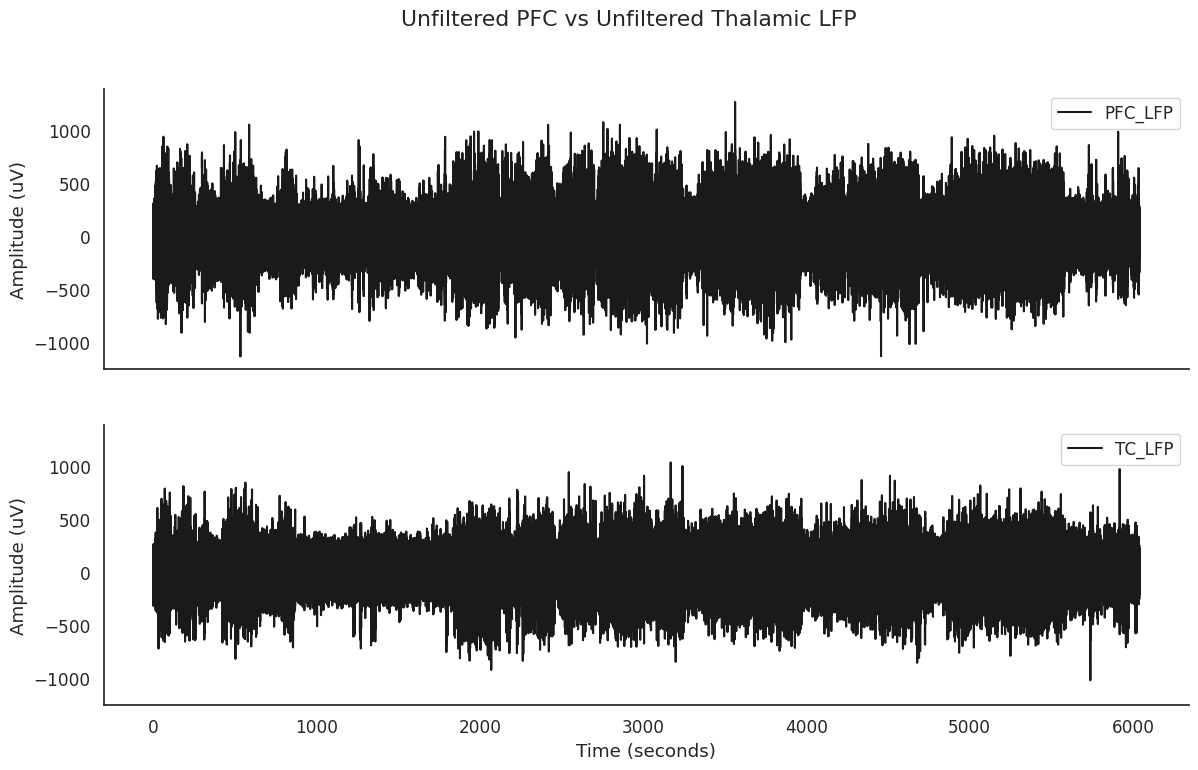

In [31]:
# Load data
data = PFC_LFP_spindle

# Define sampling frequency and time vector
sf = 600.
times = np.arange(data.size) / sf

# Plot the signal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True)
ax1.plot(times, PFC_raw, lw=1.5, color='k', label = 'PFC_LFP')
ax1.set_ylabel('Amplitude (uV)')
ax1.legend(loc=1)

ax2.plot(times,TC_LFP_spindle, lw=1.5, color='k', label = 'TC_LFP')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude (uV)')
ax2.legend(loc=1)

fig.suptitle('Unfiltered PFC vs Unfiltered Thalamic LFP')
sns.despine()

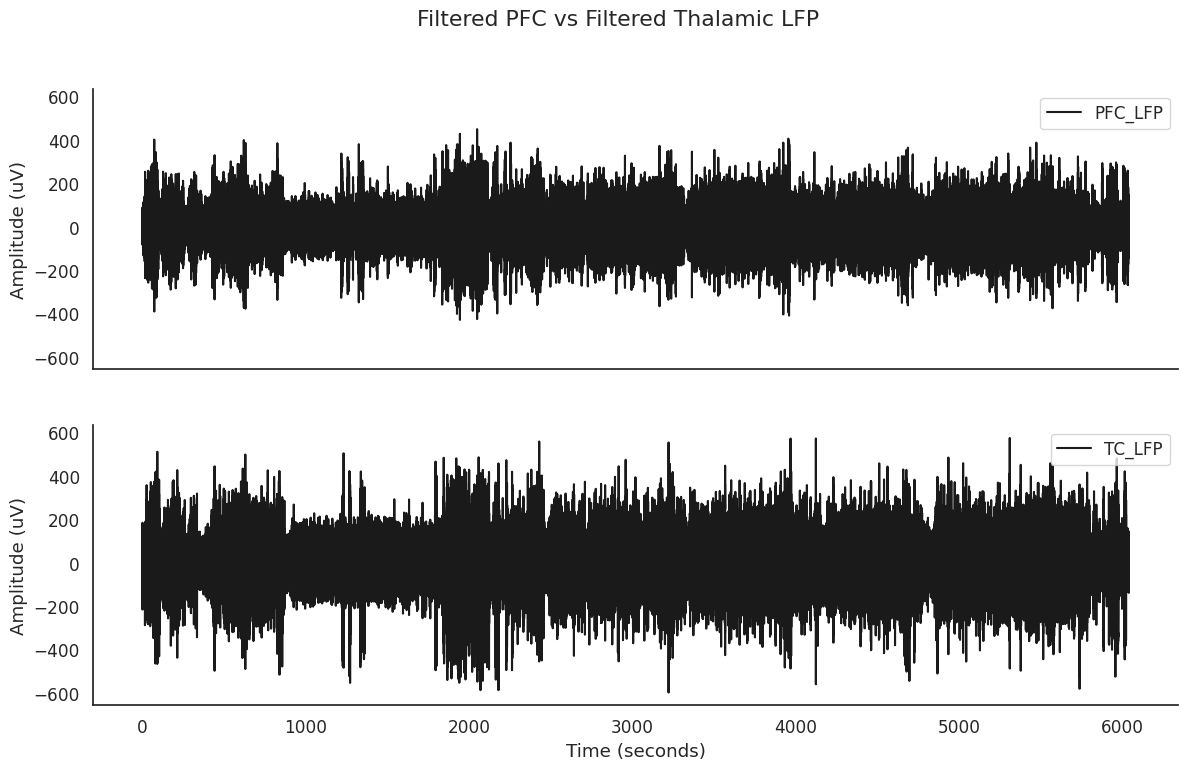

In [32]:
# Bandpass filter the LFP signals 
freq_broad = (7, 15)
filtered_TC_LFP_spindle = filter_data(TC_LFP_spindle, sf, freq_broad[0], freq_broad[1], method='fir',verbose=0) # Finite Impulse Response filter

# Load data
data = PFC_LFP_spindle

# Define sampling frequency and time vector
sf = 600.
times = np.arange(data.size) / sf

# Plot the signal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True)
ax1.plot(times, PFC_LFP_spindle, lw=1.5, color='k', label = 'PFC_LFP')
ax1.set_ylabel('Amplitude (uV)')
ax1.legend(loc=1)

ax2.plot(times,filtered_TC_LFP_spindle, lw=1.5, color='k', label = 'TC_LFP')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude (uV)')
ax2.legend(loc=1)

fig.suptitle('Filtered PFC vs Filtered Thalamic LFP')
sns.despine()

### Detect spindles from PFC and Thalamus (TC)

In [33]:
# Spindle detection PFC
pfc = yasa.spindles_detect(PFC_raw, sf, freq_sp=(7, 15), duration = (0.1, 3) , min_distance=500, thresh={'corr': 0.2, 'rel_pow': 0.2, 'rms': 0.5}, verbose=True)

pfc.summary()

08-Jan-25 16:36:45 | INFO | Number of samples in data = 3624001
08-Jan-25 16:36:45 | INFO | Sampling frequency = 600.00 Hz
08-Jan-25 16:36:45 | INFO | Data duration = 6040.00 seconds
08-Jan-25 16:36:45 | INFO | Trimmed standard deviation of CHAN000 = 121.2353 uV
08-Jan-25 16:36:45 | INFO | Peak-to-peak amplitude of CHAN000 = 2406.9771 uV
08-Jan-25 16:36:46 | INFO | Moving RMS threshold = 10.000
08-Jan-25 16:36:46 | INFO | N supra-theshold relative power = 1982091
08-Jan-25 16:36:46 | INFO | N supra-theshold moving corr = 3424500
08-Jan-25 16:36:46 | INFO | N supra-theshold moving RMS = 3623777


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,0.076667,0.151667,0.265000,0.188333,365.286222,84.887277,3.789722,0.212766,9.903255,1.0,0.394737,CHAN000,0
1,1.701667,1.963333,2.371667,0.670000,314.503128,69.283249,3.153776,0.211703,9.227904,7.0,0.389578,CHAN000,0
2,3.526667,4.850000,5.568333,2.041667,432.846911,74.041020,3.323877,0.250892,9.579253,24.0,0.647635,CHAN000,0
3,6.928333,7.296667,8.178333,1.250000,382.660881,73.849176,3.437766,0.247973,9.928238,14.0,0.294274,CHAN000,0
4,23.480000,24.306667,24.970000,1.490000,801.054761,130.737727,4.091676,0.305190,10.066663,16.0,0.554190,CHAN000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,6015.573333,6015.896667,6016.348333,0.775000,477.513762,98.743046,3.621014,0.238792,8.666583,7.0,0.416309,CHAN000,0
1011,6017.806667,6018.818333,6019.911667,2.105000,395.670153,74.956081,3.503147,0.302183,9.664479,25.0,0.480222,CHAN000,0
1012,6021.208333,6022.681667,6023.408333,2.200000,456.466520,84.310795,3.515650,0.219595,9.174396,25.0,0.669190,CHAN000,0
1013,6024.033333,6024.613333,6025.393333,1.360000,401.001016,74.595539,3.238527,0.247975,8.813742,15.0,0.425949,CHAN000,0


In [34]:
# Spindle detection TC
tc = yasa.spindles_detect(TC_raw, sf, freq_sp=(7, 15), duration = (0.1, 3) , min_distance=500, thresh={'corr': 0.2, 'rel_pow': 0.2, 'rms': 0.5}, verbose=True)

tc.summary() 

08-Jan-25 16:36:47 | INFO | Number of samples in data = 3624001
08-Jan-25 16:36:47 | INFO | Sampling frequency = 600.00 Hz
08-Jan-25 16:36:47 | INFO | Data duration = 6040.00 seconds
08-Jan-25 16:36:47 | INFO | Trimmed standard deviation of CHAN000 = 106.1686 uV
08-Jan-25 16:36:47 | INFO | Peak-to-peak amplitude of CHAN000 = 2059.9814 uV
08-Jan-25 16:36:48 | INFO | Moving RMS threshold = 10.000
08-Jan-25 16:36:48 | INFO | N supra-theshold relative power = 2560857
08-Jan-25 16:36:48 | INFO | N supra-theshold moving corr = 3492133
08-Jan-25 16:36:48 | INFO | N supra-theshold moving RMS = 3623714


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,0.081667,0.901667,2.015000,1.933333,546.829354,98.047722,3.654600,0.317479,9.112870,20.0,0.423773,CHAN000,0
1,2.601667,3.438333,4.233333,1.631667,443.952217,84.882005,3.581103,0.382783,8.873711,16.0,0.512245,CHAN000,0
2,4.945000,5.566667,5.903333,0.958333,325.653629,64.625647,3.198887,0.223439,10.401343,12.0,0.647569,CHAN000,0
3,6.450000,6.598333,7.168333,0.718333,273.453752,64.305869,3.354672,0.221173,10.733799,6.0,0.206019,CHAN000,0
4,12.556667,13.528333,14.690000,2.133333,389.158531,76.707869,3.426576,0.242041,9.183729,23.0,0.455113,CHAN000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,6004.748333,6005.705000,6006.193333,1.445000,395.390711,75.763292,3.477449,0.331830,8.679782,15.0,0.661290,CHAN000,0
699,6007.373333,6008.276667,6008.951667,1.578333,349.759431,68.385862,3.291909,0.279735,10.468328,17.0,0.571730,CHAN000,0
700,6009.500000,6010.061667,6010.381667,0.881667,392.837528,82.110456,3.487546,0.256276,10.466690,10.0,0.635849,CHAN000,0
701,6026.945000,6028.055000,6029.056667,2.111667,398.375766,82.142529,3.481421,0.280661,9.298424,22.0,0.525237,CHAN000,0


### Visualize detected spindles

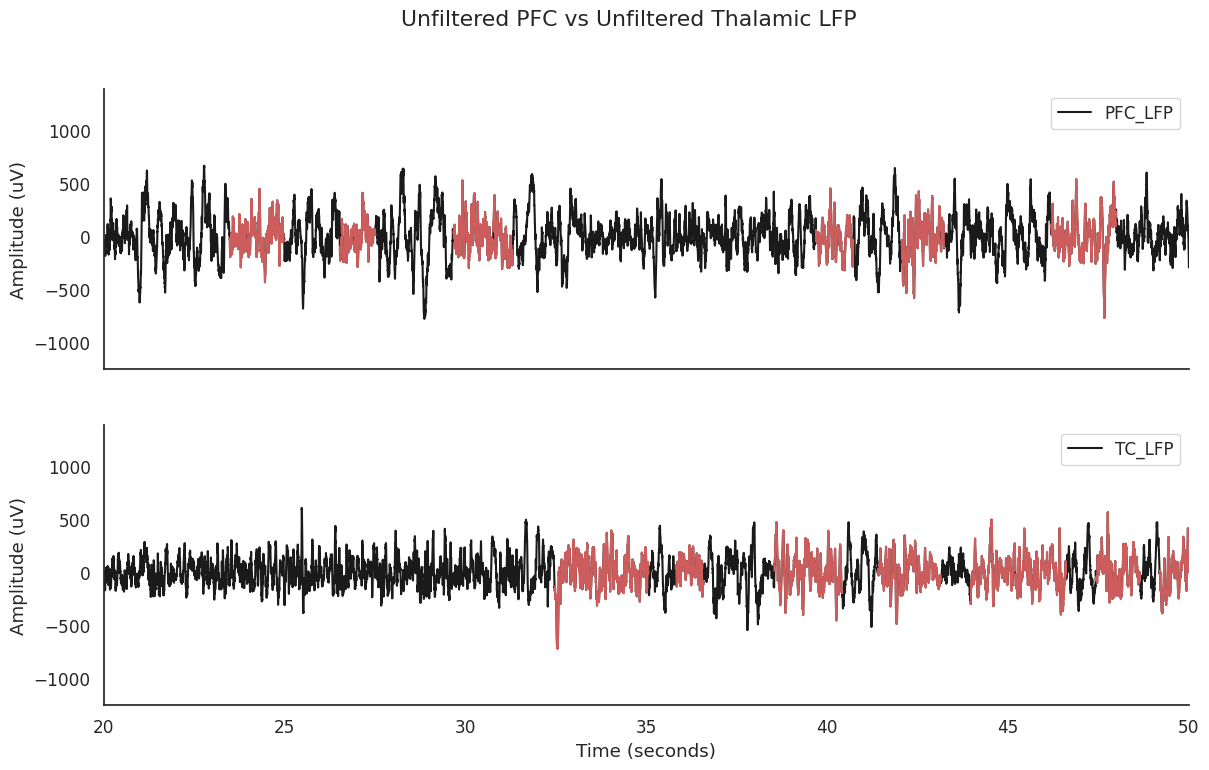

In [35]:
# Create some masks
mask_pfc = pfc.get_mask()
mask_tc = tc.get_mask()

spindles_highlight_pfc = PFC_raw * mask_pfc
spindles_highlight_pfc[spindles_highlight_pfc == 0] = np.nan

spindles_highlight_tc = TC_raw * mask_tc
spindles_highlight_tc[spindles_highlight_tc == 0] = np.nan

# Plot the signal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True)
ax1.plot(times, PFC_raw, lw=1.5, color='k', label = 'PFC_LFP')
ax1.plot(times, spindles_highlight_pfc, color='indianred')
ax1.set_ylabel('Amplitude (uV)')
ax1.legend(loc=1)

ax2.plot(times,TC_LFP_spindle, lw=1.5, color='k', label = 'TC_LFP')
ax2.plot(times, spindles_highlight_tc, color='indianred')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude (uV)')
ax2.legend(loc=1)

plt.xlim([20, 50])#times[-1]])

fig.suptitle('Unfiltered PFC vs Unfiltered Thalamic LFP')
sns.despine()

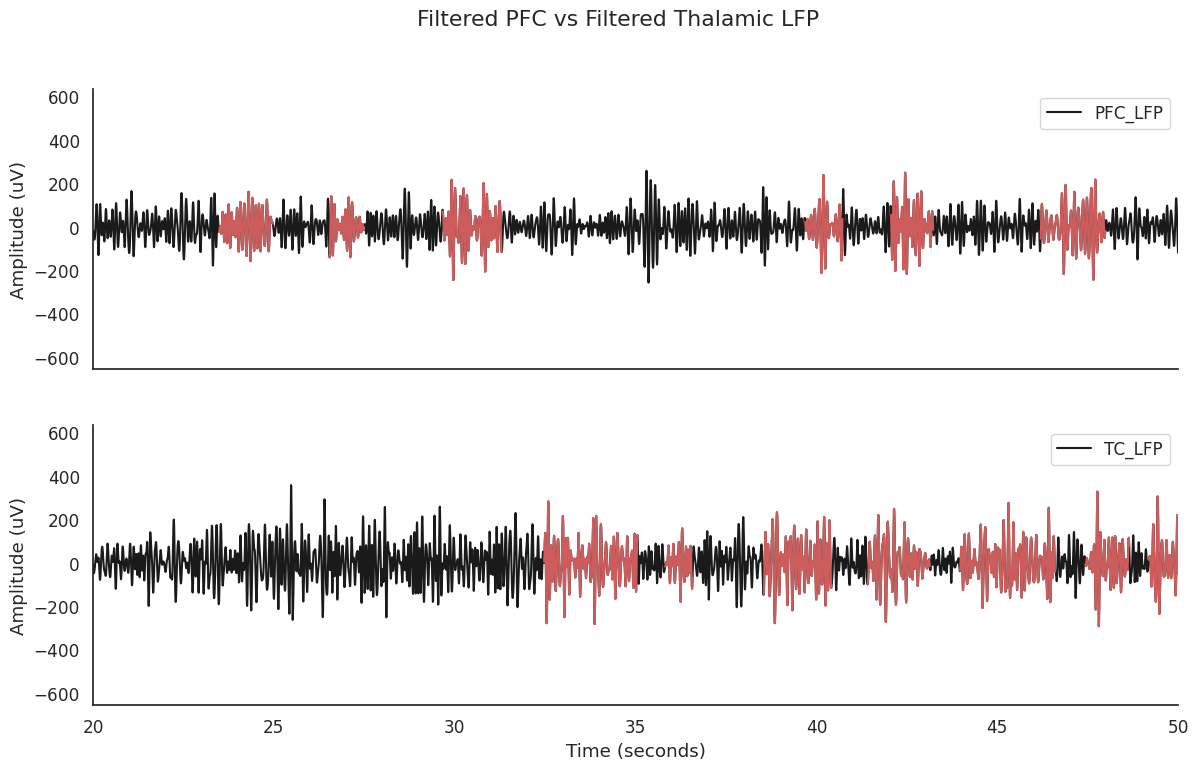

In [ ]:
# In the filtered version detected spindles have the classical spindle shape
spindles_highlight_pfc = PFC_LFP_spindle * mask_pfc
spindles_highlight_pfc[spindles_highlight_pfc == 0] = np.nan

spindles_highlight_tc = filtered_TC_LFP_spindle * mask_tc
spindles_highlight_tc[spindles_highlight_tc == 0] = np.nan

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True)
ax1.plot(times, PFC_LFP_spindle, lw=1.5, color='k', label = 'PFC_LFP')
ax1.plot(times, spindles_highlight_pfc, color='indianred')
ax1.set_ylabel('Amplitude (uV)')
ax1.legend(loc=1)

ax2.plot(times,filtered_TC_LFP_spindle, lw=1.5, color='k', label = 'TC_LFP')
ax2.plot(times, spindles_highlight_tc, color='indianred')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude (uV)')
ax2.legend(loc=1)

plt.xlim([20, 50])#times[-1]])

fig.suptitle('Filtered PFC vs Filtered Thalamic LFP')
sns.despine()

### Duration vs frequency analysis of PFC and TC spindles 

In [37]:
# Get durations and frequencies from the detected spindles
X_pfc = pfc.summary()['Duration'].to_numpy().reshape(-1, 1)
y_pfc = pfc.summary()['Frequency'].to_numpy()

X_tc = tc.summary()['Duration'].to_numpy().reshape(-1, 1)
y_tc = tc.summary()['Frequency'].to_numpy()

In [38]:
# Fit a Linear Regression to durations and frequencies
model = LinearRegression()
model.fit(X_pfc, y_pfc)
y_pred_pfc = model.predict(X_pfc)

intercept_pfc = model.intercept_
coefficient_pfc = model.coef_[0]
mse_pfc = mean_squared_error(y_pfc, y_pred_pfc)
r2_pfc = r2_score(y_pfc, y_pred_pfc)

print(f"For PFC \n Intercept: {intercept_pfc}")
print(f"Coefficient: {coefficient_pfc}")
print(f"Mean Squared Error (MSE): {mse_pfc}")
print(f"R-squared (R2): {r2_pfc}")

model = LinearRegression()
model.fit(X_tc, y_tc)
y_pred_tc = model.predict(X_tc)

intercept_tc = model.intercept_
coefficient_tc = model.coef_[0]

# Goodness-of-fit metrics
mse_tc = mean_squared_error(y_tc, y_pred_tc)
r2_tc = r2_score(y_tc, y_pred_tc)

print(f"For TC \n Intercept: {intercept_tc}")
print(f"Coefficient: {coefficient_tc}")
print(f"Mean Squared Error (MSE): {mse_tc}")
print(f"R-squared (R2): {r2_tc}")

For PFC 
 Intercept: 9.75264257432048
Coefficient: -0.08549653340536204
Mean Squared Error (MSE): 0.970946592562609
R-squared (R2): 0.003587551705224401
For TC 
 Intercept: 9.38991056681833
Coefficient: -0.015129961486634461
Mean Squared Error (MSE): 0.8324065749828088
R-squared (R2): 0.00014458104268844085


Text(0.5, 0.98, 'Duration vs Frequency')

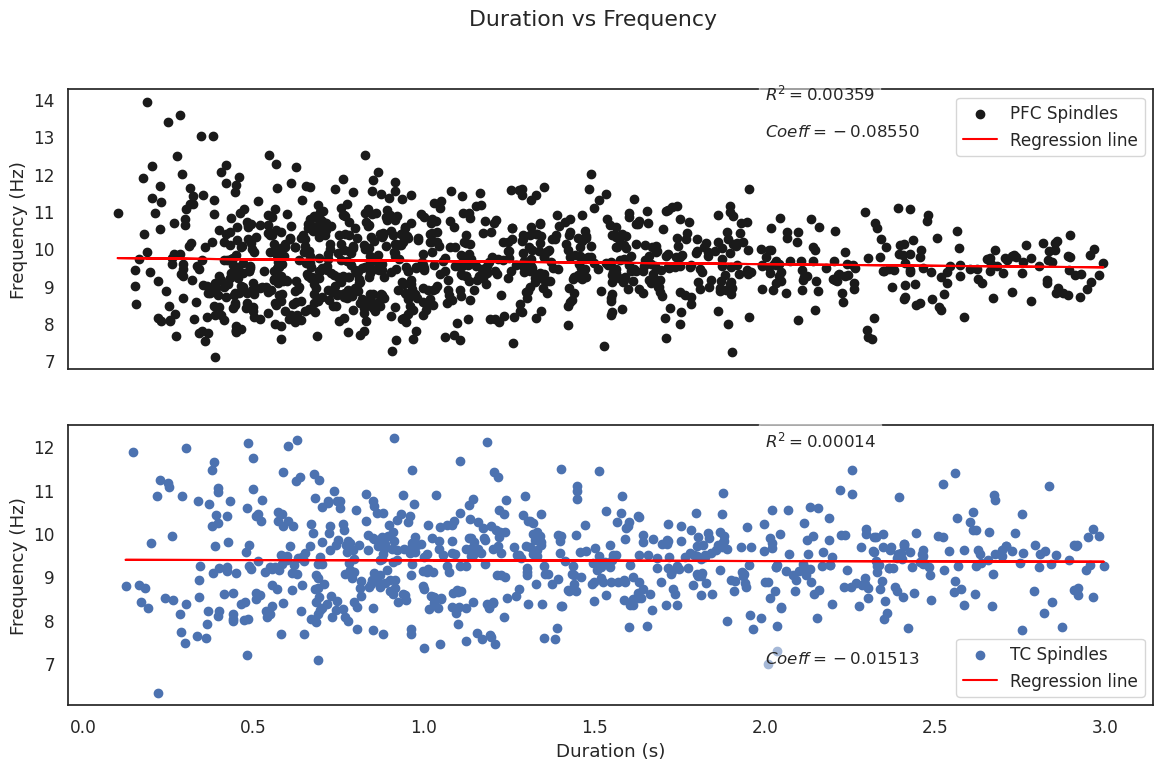

In [39]:
# Visualize linear regression
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax1.scatter(pfc.summary()['Duration'], pfc.summary()['Frequency'], label = 'PFC Spindles',color= 'k')
ax1.plot(X_pfc, y_pred_pfc, color='red', label='Regression line')
ax1.text(2, 14, f'$R^2 = {r2_pfc:.5f}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax1.text(2, 13, f'$Coeff = {coefficient_pfc:.5f}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

ax2.scatter(tc.summary()['Duration'], tc.summary()['Frequency'], label = 'TC Spindles')
ax2.plot(X_tc, y_pred_tc, color='red', label='Regression line')
ax2.text(2, 12, f'$R^2 = {r2_tc:.5f}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax2.text(2, 7, f'$Coeff = {coefficient_tc:.5f}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax1.legend()
ax2.legend()
ax2.set_xlabel('Duration (s)')
ax1.set_ylabel('Frequency (Hz)')
ax2.set_ylabel('Frequency (Hz)')

fig.suptitle('Duration vs Frequency')

### Comparison of yasa-detected spindles to spindles by Dr. Carmen Varela's algorithm

08-Jan-25 16:36:51 | INFO | Number of samples in data = 3624001
08-Jan-25 16:36:51 | INFO | Sampling frequency = 600.00 Hz
08-Jan-25 16:36:51 | INFO | Data duration = 6040.00 seconds
08-Jan-25 16:36:51 | INFO | Trimmed standard deviation of CHAN000 = 121.2353 uV
08-Jan-25 16:36:51 | INFO | Peak-to-peak amplitude of CHAN000 = 2406.9771 uV
08-Jan-25 16:36:52 | INFO | Moving RMS threshold = 10.000
08-Jan-25 16:36:52 | INFO | N supra-theshold relative power = 1982091
08-Jan-25 16:36:52 | INFO | N supra-theshold moving corr = 1524582
08-Jan-25 16:36:52 | INFO | N supra-theshold moving RMS = 3623777


Text(0.5, 0.98, 'Durations of PFC Spindles detected by Carmen and YASA')

<Figure size 400x300 with 0 Axes>

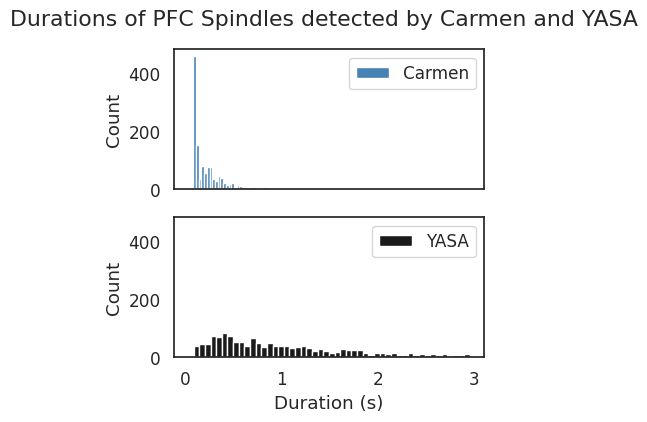

In [40]:
# Detect spindles with YASA
pfc = yasa.spindles_detect(PFC_raw, sf, freq_sp=(7, 15), duration = (0, 3), min_distance=500, thresh={'corr': 0.65, 'rel_pow': 0.2, 'rms': 1.5}, verbose=True)


# Spike duration distribution. Get durations of spindles as detected in the given dataset
plt.figure(figsize=(4,3))
spindle_starts = spindle_start_end[:,0]
spindle_ends = spindle_start_end[:,1]
spindle_durations = spindle_ends - spindle_starts
intervals = spindle_durations

mean = np.mean(intervals)
std = np.std(intervals)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), sharex=True, sharey=True)
ax1.hist(intervals, bins=50, color='steelblue', label = 'Carmen')
ax2.hist(pfc.summary()['Duration'], bins=50, label = 'YASA',color= 'k')
ax1.legend()
ax2.legend()
ax2.set_xlabel('Duration (s)')
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')

fig.suptitle('Durations of PFC Spindles detected by Carmen and YASA')

## Slow wave detection

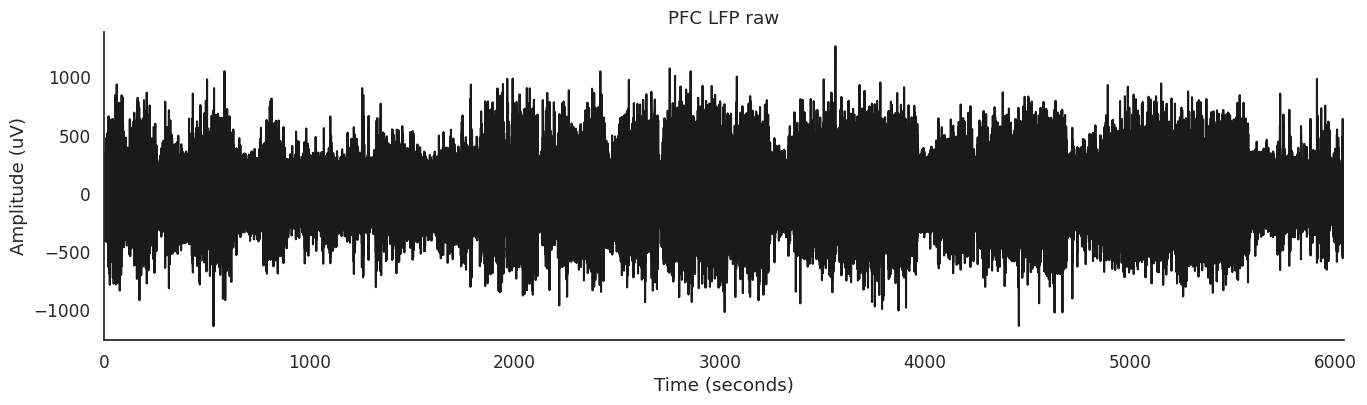

In [41]:
# Load data
data = PFC_raw

# Define sampling frequency and time vector
sf = 600.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('PFC LFP raw')
sns.despine()

In [42]:
# Detect slow waves in PFC
sw = yasa.sw_detect(data, sf, hypno=None, # include=(2, 3), 
               freq_sw=(0.3, 1.5),
               dur_neg=(0.1, 1.5), dur_pos=(0.1, 1), amp_neg=(40, 200),
               amp_pos=(10, 150), amp_ptp=(75, 350), coupling=False,
               remove_outliers=True, verbose=False)

events = sw.summary()
events.round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,0.64,0.81,0.99,1.16,1.32,0.68,-53.55,51.22,104.77,598.70,1.47,CHAN000,0
1,1.32,1.52,1.70,1.92,2.17,0.85,-66.44,82.20,148.64,803.47,1.18,CHAN000,0
2,6.23,6.48,6.70,6.92,7.16,0.94,-44.53,43.14,87.67,392.57,1.07,CHAN000,0
3,12.20,12.41,12.60,12.78,12.97,0.77,-115.80,97.94,213.74,1086.81,1.30,CHAN000,0
4,12.97,13.14,13.32,13.51,13.72,0.75,-80.94,87.60,168.54,963.11,1.34,CHAN000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,6030.01,6030.19,6030.38,6030.54,6030.72,0.71,-76.79,56.34,133.12,700.66,1.41,CHAN000,0
2693,6030.72,6030.88,6031.04,6031.22,6031.43,0.71,-42.75,45.22,87.97,538.57,1.41,CHAN000,0
2694,6032.62,6032.78,6032.93,6033.10,6033.26,0.64,-56.22,68.25,124.47,811.74,1.57,CHAN000,0
2695,6033.26,6033.48,6033.70,6033.85,6034.04,0.78,-114.40,49.04,163.44,721.06,1.28,CHAN000,0


This is a description of the detected parameters from the yasa package documentation: \
The output of the slow-waves detection is a [SWResults](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html#yasa.SWResults) class, which comes with some pre-compiled functions (also called methods). For instance, the [summary](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html#yasa.SWResults.summary) method returns a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) with all the detected slow-waves and their properties. The different slow-waves properties are explained in the figure below:

<img src="https://raw.githubusercontent.com/raphaelvallat/yasa/master/docs/pictures/slow_waves.png" alt="slow-waves" style="width: 600px;"/>

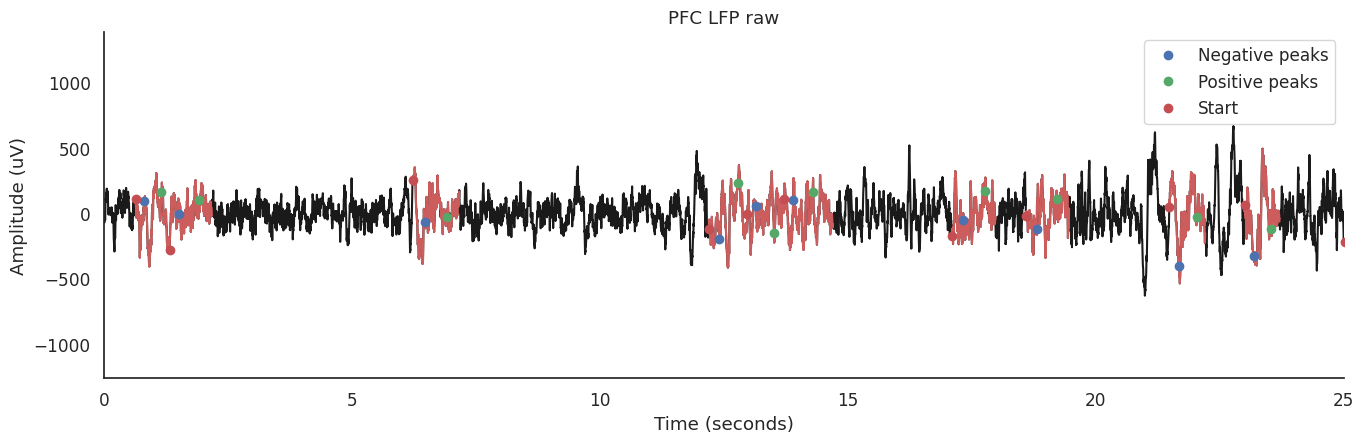

In [43]:
# Get some masks for slow waves and plot the unfiltered signal
mask = sw.get_mask()
sw_highlight = data * mask
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))

plt.plot(times, data, 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(events['NegPeak'], sw_highlight[(events['NegPeak'] * sf).astype(int)], 'bo', label='Negative peaks')
plt.plot(events['PosPeak'], sw_highlight[(events['PosPeak'] * sf).astype(int)], 'go', label='Positive peaks')
plt.plot(events['Start'], data[(events['Start'] * sf).astype(int)], 'ro', label='Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, 25])
plt.title('PFC LFP raw')
plt.legend()
sns.despine()

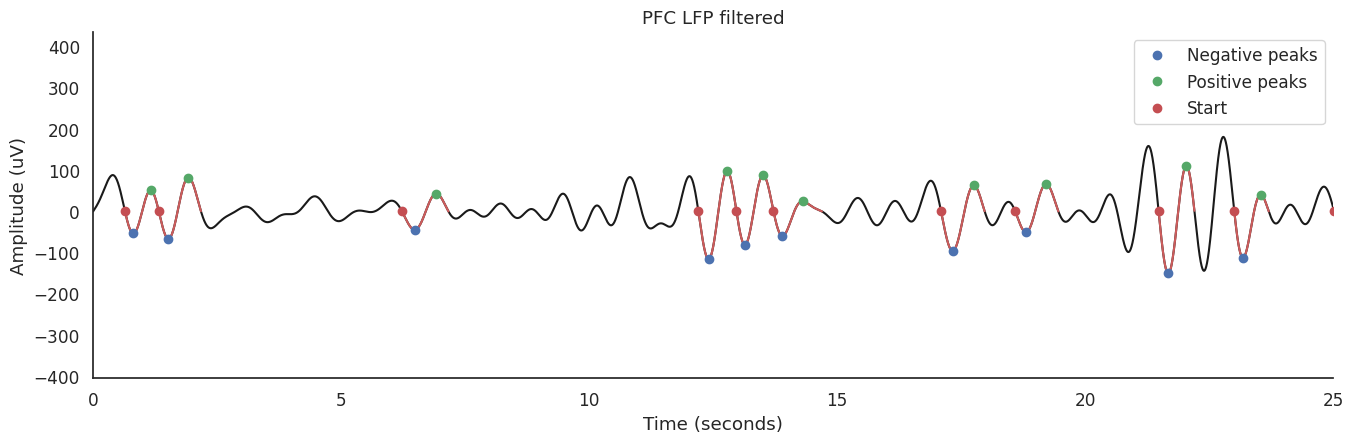

In [44]:
# Get the filtered signal
data_filt = np.squeeze(sw._data_filt)

# Apply masks
sw_highlight = data_filt * mask
sw_highlight[sw_highlight == 0] = np.nan

# Plot
plt.figure(figsize=(16, 4.5))

plt.plot(times, data_filt, 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(events['NegPeak'], events['ValNegPeak'], 'bo', label='Negative peaks')
plt.plot(events['PosPeak'], events['ValPosPeak'], 'go', label='Positive peaks')
plt.plot(events['Start'], np.squeeze(sw._data_filt)[(events['Start'] * sf).astype(int)], 'ro', label='Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, 25])
plt.title('PFC LFP filtered')
plt.legend()
sns.despine()

In [ ]:
# Plot an average slow wave
sw.plot_average(time_before=0.4, time_after=0.8, center="Start")

## Spindle-slow wave coupling

In [46]:
# detect slow waves and coupled spindles
sw = yasa.sw_detect(data, sf, ch_names=["Cz"], hypno=None, include=(2, 3), coupling=True,
                    coupling_params=dict(freq_sp=(7, 15), time=0.5, p=None))
events = sw.summary()
events.round(3)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Channel,IdxChannel
0,0.642,0.812,0.987,1.158,1.323,0.682,-53.552,51.220,104.772,598.695,1.467,1.198,0.557,0.144,Cz,0
1,1.323,1.518,1.703,1.922,2.173,0.850,-66.439,82.202,148.641,803.466,1.176,1.485,2.870,0.303,Cz,0
2,6.227,6.482,6.705,6.920,7.163,0.937,-44.530,43.144,87.674,392.572,1.068,6.178,1.271,0.397,Cz,0
3,11.058,11.242,11.795,12.022,12.202,1.143,-41.348,85.496,126.844,229.237,0.875,11.392,3.038,0.259,Cz,0
4,12.202,12.408,12.605,12.783,12.970,0.768,-115.804,97.936,213.739,1086.811,1.302,12.578,-1.790,0.485,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,6031.432,6032.018,6032.187,6032.413,6032.620,1.188,-43.359,87.445,130.804,777.054,0.842,6032.045,-2.481,0.421,Cz,0
3377,6032.620,6032.775,6032.928,6033.102,6033.258,0.638,-56.221,68.246,124.466,811.737,1.567,6033.245,1.462,0.279,Cz,0
3378,6033.258,6033.475,6033.702,6033.848,6034.038,0.780,-114.401,49.040,163.441,721.063,1.282,6033.945,0.053,0.341,Cz,0
3379,6034.655,6034.832,6035.047,6035.163,6035.298,0.643,-61.201,20.053,81.254,377.926,1.554,6034.963,-2.323,0.211,Cz,0


In [47]:
# Detect spindles
pfc = yasa.spindles_detect(PFC_raw, sf, freq_sp=(6, 14), duration = (0.1, 3) , min_distance=300, thresh={'corr': 0.2, 'rel_pow': 0.4, 'rms': 0.5}, verbose=True)
data_filt = np.squeeze(pfc._data_filt)

pfc_spindles = pfc.summary() # this is a pandas dataframe

pfc_spindles

08-Jan-25 16:37:26 | INFO | Number of samples in data = 3624001
08-Jan-25 16:37:26 | INFO | Sampling frequency = 600.00 Hz
08-Jan-25 16:37:26 | INFO | Data duration = 6040.00 seconds
08-Jan-25 16:37:26 | INFO | Trimmed standard deviation of CHAN000 = 121.2353 uV
08-Jan-25 16:37:26 | INFO | Peak-to-peak amplitude of CHAN000 = 2406.9771 uV
08-Jan-25 16:37:27 | INFO | Moving RMS threshold = 10.000
08-Jan-25 16:37:27 | INFO | N supra-theshold relative power = 1092311
08-Jan-25 16:37:27 | INFO | N supra-theshold moving corr = 3491030
08-Jan-25 16:37:27 | INFO | N supra-theshold moving RMS = 3623767


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,4.033333,4.851667,5.371667,1.338333,433.943258,78.991733,3.541272,0.504356,8.437814,15.0,0.610697,CHAN000,0
1,17.976667,18.565000,18.698333,0.721667,486.678083,99.178084,4.018914,0.460127,8.922815,8.0,0.813364,CHAN000,0
2,19.426667,19.865000,20.420000,0.993333,575.381997,124.062092,4.125317,0.516639,9.863940,11.0,0.440536,CHAN000,0
3,29.900000,30.798333,31.005000,1.105000,673.798900,149.737732,4.186398,0.458845,10.299566,11.0,0.811747,CHAN000,0
4,34.506667,35.411667,36.756667,2.250000,1045.820993,158.011020,4.236905,0.427863,8.576480,24.0,0.401925,CHAN000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,6022.550000,6023.148333,6023.515000,0.965000,448.897542,85.343970,3.856771,0.494447,6.881760,11.0,0.618966,CHAN000,0
1043,6024.756667,6024.935000,6025.118333,0.361667,324.011214,70.174938,3.718697,0.411140,7.401029,5.0,0.490826,CHAN000,0
1044,6026.761667,6027.055000,6027.321667,0.560000,255.029760,46.725902,3.307936,0.416086,9.314363,6.0,0.522255,CHAN000,0
1045,6028.965000,6029.136667,6029.211667,0.246667,268.784125,75.539481,3.884808,0.402642,6.522628,4.0,0.691275,CHAN000,0


In [ ]:
# Plot average spindle
pfc.plot_average(time_before=0.5, time_after=0.5);

The circular mean is: 0.0981963486842129


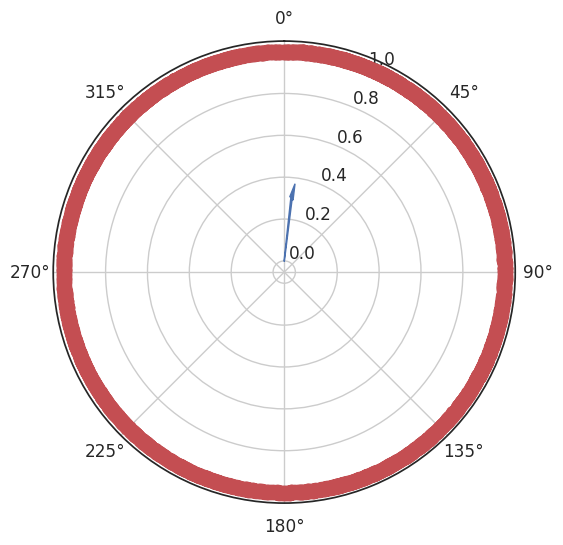

In [49]:
# Plot phase amplitude-coupling

angles = events['PhaseAtSigmaPeak']
# Convert angles to complex numbers
complex_numbers = np.exp(1j * np.array(angles))

# Compute the mean of the complex numbers
mean_complex = np.mean(complex_numbers)

# Convert the mean complex number back to an angle
circular_mean = np.angle(mean_complex)

print("The circular mean is:", circular_mean)


plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('N')  
ax.set_theta_direction(-1) 

# Plot the points
ax.scatter(angles, [1]*len(angles), c='r', s=100)

ax.arrow(0, 0, circular_mean , np.mean(events['ndPAC']), color='b', width=0.02, head_width=0.05)

### From here repeat the analysis with Spindles within +-1 sec of SO downstate
Coupled spindles are within 1 sec of SO downstate \
Uncoupled spindles are not within 1 sec of SO downstate

In [50]:
# Filter spindle-slow wave couples that are within 1s of each other
# from this we get couple slow oscillations
result = events[events['NegPeak'].apply(lambda v: any(abs(v - pfc_spindles['Peak']) <= 1))]

# get coupled spindles
coupled_spindles = pfc_spindles[pfc_spindles['Peak'].apply(lambda v: any(abs(v - result['NegPeak']) <= 1))]


In [51]:
# get the uncoupled slow oscillations
merged_df = result.merge(events, how='outer', indicator=True)
uncoupled_SO = merged_df[merged_df['_merge'] == 'right_only'].drop(columns=['_merge'])

# get the uncoupled spindles
merged_df = coupled_spindles.merge(pfc_spindles, how='outer', indicator=True)
uncoupled_spindles = merged_df[merged_df['_merge'] == 'right_only'].drop(columns=['_merge'])

Two-sample t-test results: t-statistic = 7.1303, p-value = 0.0000
The difference in means of Amplitude is statistically significant.


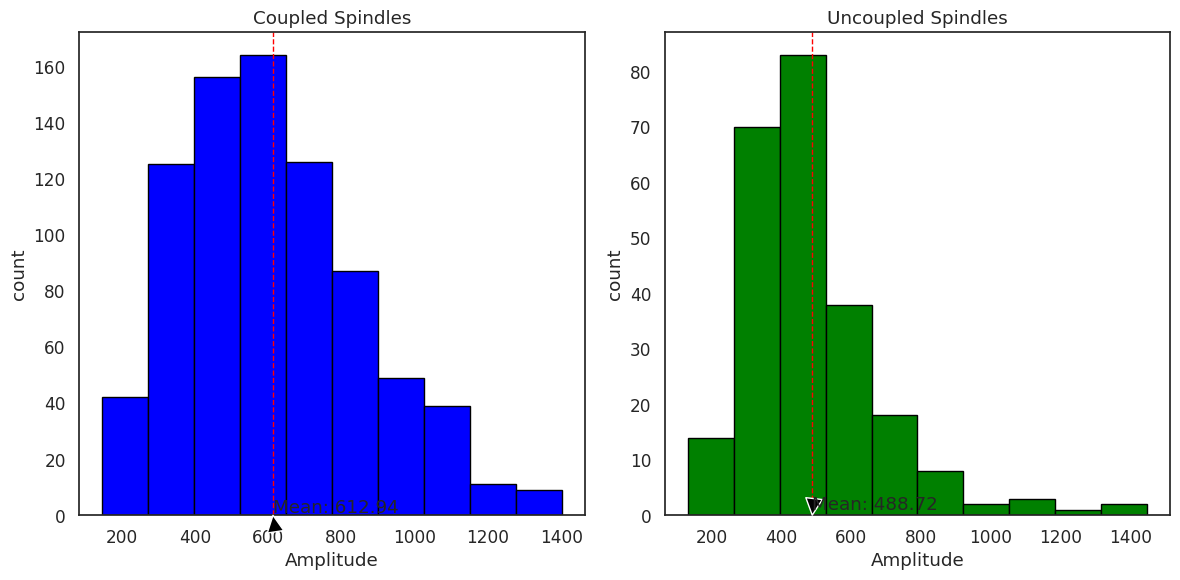

In [52]:
# Compare coupled and uncoupled spindles
from scipy.stats import ttest_ind

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

param = 'Amplitude' # can be Frequency, Duration, etc.

t_stat, p_value = ttest_ind(coupled_spindles[param], uncoupled_spindles[param])

print(f'Two-sample t-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')


alpha = 0.05
if p_value < alpha:
    print(f"The difference in means of {param} is statistically significant.")
else:
    print(f"The difference in means of {param} is not statistically significant.")

# Plot
axes[0].hist(coupled_spindles[param], bins=10, color='blue', edgecolor='black')
axes[0].axvline(np.mean(coupled_spindles[param]), color='red', linestyle='dashed', linewidth=1)
axes[0].set_title('Coupled Spindles')
axes[0].set_xlabel(param)
axes[0].set_ylabel('count')
axes[0].annotate(f'Mean: {np.mean(coupled_spindles[param]):.2f}', xy=(np.mean(coupled_spindles[param]), 0), xytext=(np.mean(coupled_spindles[param]) + 0.5, 1),
                 arrowprops=dict(facecolor='black', shrink=0.05))

axes[1].hist(uncoupled_spindles[param], bins=10, color='green', edgecolor='black')
axes[1].axvline(np.mean(uncoupled_spindles[param]), color='red', linestyle='dashed', linewidth=1)
axes[1].set_title('Uncoupled Spindles')
axes[1].set_xlabel(param)
axes[1].set_ylabel('count')
axes[1].annotate(f'Mean: {np.mean(uncoupled_spindles[param]):.2f}', xy=(np.mean(uncoupled_spindles[param]), 0), xytext=(np.mean(uncoupled_spindles[param]) + 0.5, 1),
                 arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

The circular mean is: 0.25687355559553265


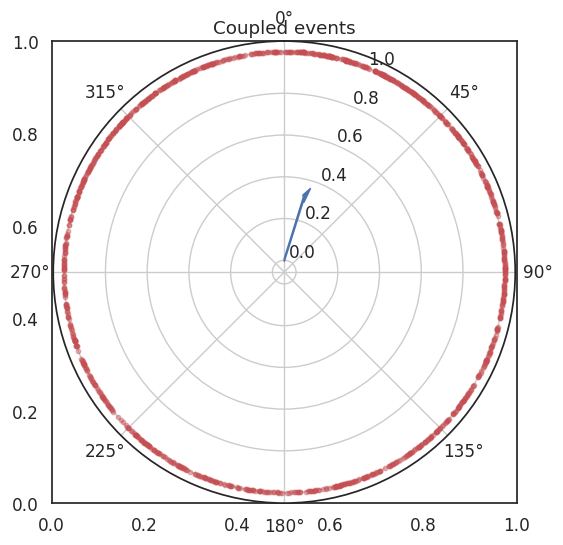

In [53]:
# phase-amplitude coupling for coupled spindles and slow waves

angles = result['PhaseAtSigmaPeak']
# Convert angles to complex numbers
complex_numbers = np.exp(1j * np.array(angles))

# Compute the mean of the complex numbers
mean_complex = np.mean(complex_numbers)

# Convert the mean complex number back to an angle
circular_mean = np.angle(mean_complex)

print("The circular mean is:", circular_mean)

plt.figure(figsize=(6, 6))
plt.title("Coupled events")
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1)

ax.scatter(angles, [1]*len(angles), c='r', s=10, alpha=0.4)

ax.arrow(0, 0, circular_mean , np.mean(result['ndPAC']), color='b', width=0.02, head_width=0.05)

The circular mean is: 0.03676553942935088


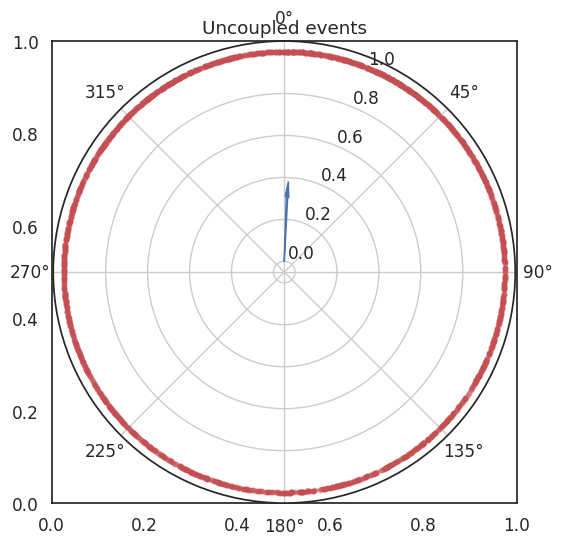

In [54]:
# phase-amplitude coupling for uncoupled spindles and slow waves

uncoupled_SO = uncoupled_SO[uncoupled_SO['PhaseAtSigmaPeak'].notna()]
angles = uncoupled_SO['PhaseAtSigmaPeak']
# Convert angles to complex numbers
complex_numbers = np.exp(1j * np.array(angles))

# Compute the mean of the complex numbers
mean_complex = np.mean(complex_numbers)

# Convert the mean complex number back to an angle
circular_mean = np.angle(mean_complex)

print("The circular mean is:", circular_mean)
# plt.hist(events_coupled['ndPAC'])

plt.figure(figsize=(6, 6))
plt.title("Uncoupled events")
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('N')  # Zero degrees is at the top
ax.set_theta_direction(-1)  # Angles increase clockwise

# Plot the points
ax.scatter(angles, [1]*len(angles), c='r', s=10, alpha=0.4)

ax.arrow(0, 0, circular_mean , np.mean(result['ndPAC']), color='b', width=0.02, head_width=0.05)



## Data-driven PAC

`yasa` also offers a data-driven way to see phase-amplitude coupling (PAC). Here you can find the adaptation from `yasa` tutorials about data-driven PAC to our data.  

In [55]:
# Segment N2 sleep into 15-seconds non-overlapping epochs
_, data_N2 = yasa.sliding_window(data, sf, window=15)

data_N2.shape

(402, 9000)

In [56]:
# First, let's define our array of frequencies for phase and amplitude
f_pha = np.arange(0.375, 2.25, 0.25)  # Frequency for phase
f_amp = np.arange(7.25, 15.5, 0.25)  # Frequency for amplitude

f_pha, f_amp

(array([0.375, 0.625, 0.875, 1.125, 1.375, 1.625, 1.875, 2.125]),
 array([ 7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,
         9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 ,
        11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75,
        14.  , 14.25, 14.5 , 14.75, 15.  , 15.25]))

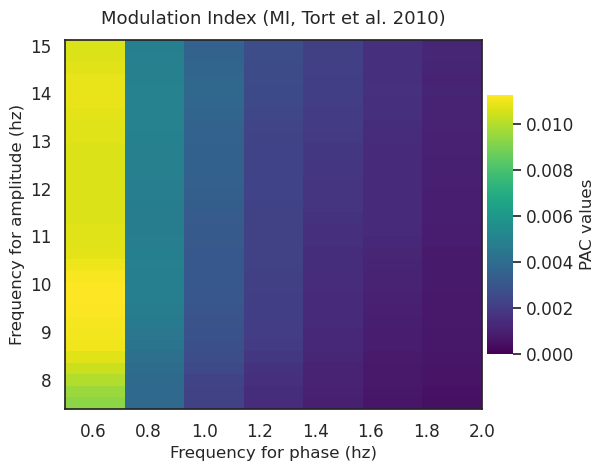

In [57]:
# Plot a comodulogram

sns.set(font_scale=1.1, style='white')

# Define a PAC object
p = Pac(idpac=(2, 0, 0), f_pha=f_pha, f_amp=f_amp, verbose='WARNING')

# Filter the data and extract the PAC values
xpac = p.filterfit(sf, data_N2)

p.comodulogram(xpac.mean(-1), title=str(p), vmin=0, plotas='imshow');

In [58]:
# Get the pac values
df_pac = pd.DataFrame(xpac.mean(-1), columns=p.xvec, index=p.yvec)
df_pac.columns.name = 'FreqPhase'
df_pac.index.name = 'FreqAmplitude'
df_pac.head(20).style.highlight_max(axis=None)

FreqPhase,0.500000,0.750000,1.000000,1.250000,1.500000,1.750000,2.000000
FreqAmplitude,,,,,,,
7.375000,0.009312,0.003845,0.002164,0.001418,0.000984,0.000690,0.000523
7.625000,0.009573,0.003854,0.002189,0.001495,0.001021,0.000733,0.000558
7.875000,0.009970,0.003906,0.002322,0.001579,0.001077,0.000771,0.000594
8.125000,0.010351,0.003977,0.002479,0.001671,0.001119,0.000775,0.000618
8.375000,0.010741,0.004151,0.002650,0.001840,0.001190,0.000806,0.000663
8.625000,0.011027,0.004340,0.002759,0.001971,0.001239,0.000854,0.000708
8.875000,0.011098,0.004485,0.002830,0.002028,0.001277,0.000910,0.000740
9.125000,0.011124,0.004636,0.002905,0.002055,0.001321,0.000961,0.000765
9.375000,0.011221,0.004759,0.002983,0.002071,0.001367,0.001007,0.000781
